## Imports

In [1]:
from collections import defaultdict

import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, DotProduct, WhiteKernel
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor

from sklearn.model_selection import KFold

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from prettytable import PrettyTable

%matplotlib inline

## Load the datasets

In [2]:
df_p = pd.read_csv("dataset/parsec_dataset.csv")
df_s = pd.read_csv("dataset/splash_dataset.csv")

del df_p['workload']
del df_p['size']
del df_s['name']
del df_s['size']
del df_s['single-thread-time']

df_p.rename(columns={'IPC': 'ipc', 'run_time': 'real-time', 'thread': 'threads'}, inplace=True)

In [3]:
df = pd.concat([df_p, df_s], axis=0)

In [4]:
def scale_data(data):
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(data)
    return scaled_data

## Global vars

In [5]:
FEATURES = ['cache-miss-rate', 'L1-icache-load-misses', 'cpu-clock', 'LLC-load-misses', 'page-faults', 'instructions']
TARGET = 'real-time'
THREADS = [2,4,8,16,32]
MODELS = ["linear_regression", "lasso", "ridge", "svr", "decision_tree", "random_forest", "ada_boost", "gradient_boost", "gaussian"]

## Running different ML models

In [6]:
results = defaultdict(dict)

for thread in THREADS:
    thread_df = df[df['threads'] == thread]
    thread_X, thread_Y = scale_data(thread_df[FEATURES].values), thread_df[TARGET].values
    
    k_fold = KFold(n_splits=thread_X.shape[0])
    predicted_mapping = defaultdict(lambda: defaultdict(list))
    
    for train_index, test_index in k_fold.split(thread_X):
        thread_X_train, thread_Y_train = thread_X[train_index], thread_Y[train_index]
        thread_X_test, thread_Y_test = thread_X[test_index], thread_Y[test_index]
        
        lr = LinearRegression()
        lr.fit(thread_X_train, thread_Y_train)
        thread_X_test_preds = lr.predict(thread_X_test)
        predicted_mapping["linear_regression"]["actual"].append(thread_Y_test[0])
        predicted_mapping["linear_regression"]["predicted"].append(thread_X_test_preds[0])
        
        lasso = Lasso(max_iter=10000, random_state=42)
        lasso.fit(thread_X_train, thread_Y_train)
        thread_X_test_preds = lasso.predict(thread_X_test)
        predicted_mapping["lasso"]["actual"].append(thread_Y_test[0])
        predicted_mapping["lasso"]["predicted"].append(thread_X_test_preds[0])
        
        ridge = Ridge(max_iter=10000, random_state=42)
        ridge.fit(thread_X_train, thread_Y_train)
        thread_X_test_preds = ridge.predict(thread_X_test)
        predicted_mapping["ridge"]["actual"].append(thread_Y_test[0])
        predicted_mapping["ridge"]["predicted"].append(thread_X_test_preds[0])
        
        svr = SVR()
        svr.fit(thread_X_train, thread_Y_train)
        thread_X_test_preds = svr.predict(thread_X_test)
        predicted_mapping["svr"]["actual"].append(thread_Y_test[0])
        predicted_mapping["svr"]["predicted"].append(thread_X_test_preds[0])
        
        decision_tree = DecisionTreeRegressor(random_state=42)
        decision_tree.fit(thread_X_train, thread_Y_train)
        thread_X_test_preds = decision_tree.predict(thread_X_test)
        predicted_mapping["decision_tree"]["actual"].append(thread_Y_test[0])
        predicted_mapping["decision_tree"]["predicted"].append(thread_X_test_preds[0])
        
        random_forest = RandomForestRegressor(random_state=42)
        random_forest.fit(thread_X_train, thread_Y_train)
        thread_X_test_preds = random_forest.predict(thread_X_test)
        predicted_mapping["random_forest"]["actual"].append(thread_Y_test[0])
        predicted_mapping["random_forest"]["predicted"].append(thread_X_test_preds[0])
        
        ada_boost = AdaBoostRegressor(random_state=42)
        ada_boost.fit(thread_X_train, thread_Y_train)
        thread_X_test_preds = ada_boost.predict(thread_X_test)
        predicted_mapping["ada_boost"]["actual"].append(thread_Y_test[0])
        predicted_mapping["ada_boost"]["predicted"].append(thread_X_test_preds[0])
        
        gradient_boost = GradientBoostingRegressor(random_state=42)
        gradient_boost.fit(thread_X_train, thread_Y_train)
        thread_X_test_preds = gradient_boost.predict(thread_X_test)
        predicted_mapping["gradient_boost"]["actual"].append(thread_Y_test[0])
        predicted_mapping["gradient_boost"]["predicted"].append(thread_X_test_preds[0])
        
        kernel = DotProduct() + WhiteKernel()
        gaussian = GaussianProcessRegressor(kernel=kernel, random_state=42)
        gaussian.fit(thread_X_train, thread_Y_train)
        thread_X_test_preds = gaussian.predict(thread_X_test)
        predicted_mapping["gaussian"]["actual"].append(thread_Y_test[0])
        predicted_mapping["gaussian"]["predicted"].append(thread_X_test_preds[0])
        
    for key in predicted_mapping.keys():
        mae = mean_absolute_error(predicted_mapping[key]["actual"], predicted_mapping[key]["predicted"])
        mse = mean_absolute_error(predicted_mapping[key]["actual"], predicted_mapping[key]["predicted"])
        r2score = r2_score(predicted_mapping[key]["actual"], predicted_mapping[key]["predicted"])
        adjusted_r2score = 1 - ((1 - r2score) * (len(predicted_mapping[key]["actual"]) - 1) / (len(predicted_mapping[key]["actual"]) - thread_X.shape[1] - 1))
        predicted_mapping[key]["mae"] = mae
        predicted_mapping[key]["mse"] = mse
        predicted_mapping[key]["r2score"] = r2score
        predicted_mapping[key]["adj_r2score"] = adjusted_r2score    
    results[thread] = predicted_mapping

## Scatter plots for execution time

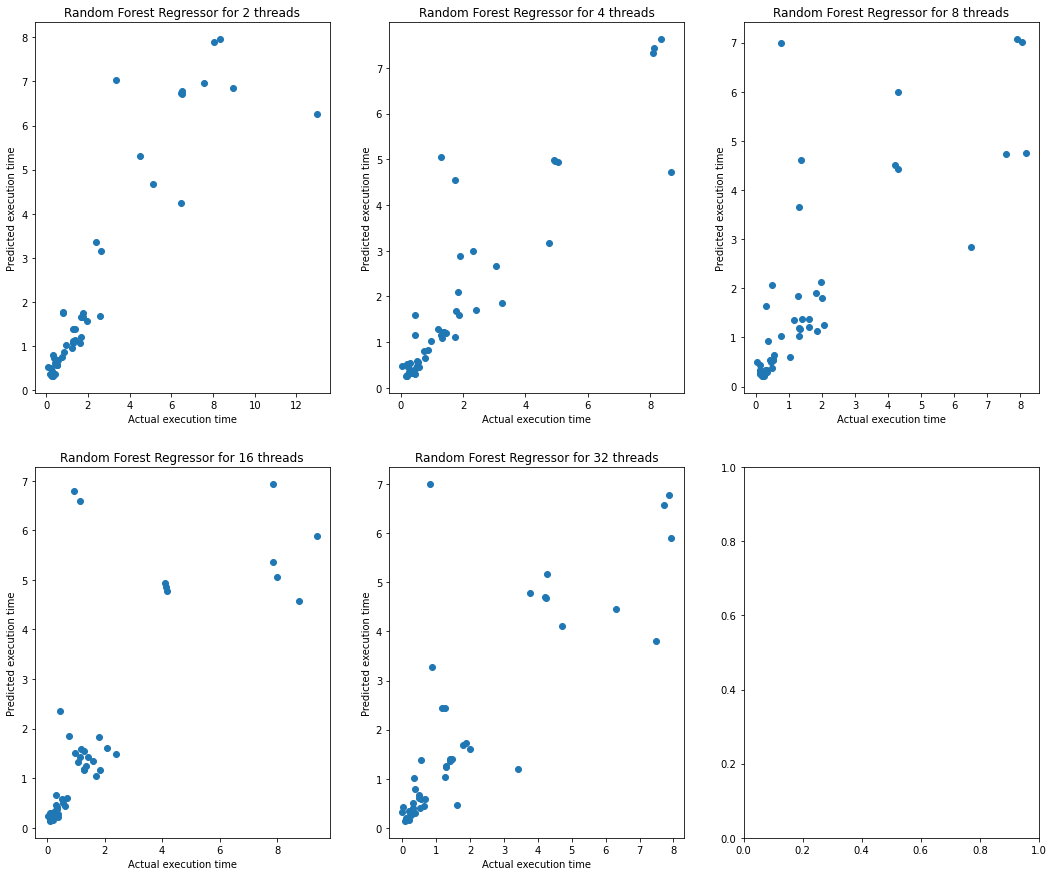

In [7]:
fig, ax = plt.subplots(2, 3, figsize=(18,15))
model = "random_forest"
for index, thread in enumerate(THREADS):
    ax[index // 3][index % 3].scatter(results[thread][model]["actual"], results[thread][model]["predicted"])
    ax[index // 3][index % 3].set_title("Random Forest Regressor for {} threads".format(thread))
    ax[index // 3][index % 3].set_xlabel("Actual execution time")
    ax[index // 3][index % 3].set_ylabel("Predicted execution time")

## Compiling  results for different threads

In [8]:
for thread in THREADS:
    print("Results for thread {}".format(thread))
    table = PrettyTable(["model", "mae", "mse", "r2_score", "adj_r2score"])
    result = results[thread]
    for model in result:
        table.add_row([model, result[model].get("mae"), result[model].get("mse"), result[model].get("r2score"), result[model].get("adj_r2score")])
    print(table)
    print("\n")

Results for thread 2
+-------------------+--------------------+--------------------+--------------------+--------------------+
|       model       |        mae         |        mse         |      r2_score      |    adj_r2score     |
+-------------------+--------------------+--------------------+--------------------+--------------------+
| linear_regression | 0.7775734298158657 | 0.7775734298158657 | 0.7362019899918568 | 0.7002295340816556 |
|       lasso       | 1.2926229622560594 | 1.2926229622560594 | 0.5313905175372613 | 0.4674892244741605 |
|       ridge       |  0.81962534128815  |  0.81962534128815  | 0.7304492429569882 | 0.6936923215420321 |
|        svr        | 0.8507308340514171 | 0.8507308340514171 | 0.6504671972224902 | 0.6028036332073752 |
|   decision_tree   | 0.5604784313725492 | 0.5604784313725492 | 0.8431298048025196 | 0.8217384145483178 |
|   random_forest   | 0.5391684313725491 | 0.5391684313725491 | 0.8241482418387253 | 0.8001684566349151 |
|     ada_boost     | 0.8

In [9]:
table = PrettyTable(["model", "thread_2", "thread_4", "thread_8", "thread_16", "thread_32"])
for model in MODELS:
    row = [model]
    for thread in THREADS:
        row.append(round(results[thread][model].get("r2score"), 4))
    table.add_row(row)
print(table)

print("\n" + "*"*50 + "\n")

table = PrettyTable(["model", "thread_2", "thread_4", "thread_8", "thread_16", "thread_32"])
for model in MODELS:
    row = [model]
    for thread in THREADS:
        row.append(round(results[thread][model].get("mae"), 4))
    table.add_row(row)
print(table)

+-------------------+----------+----------+----------+-----------+-----------+
|       model       | thread_2 | thread_4 | thread_8 | thread_16 | thread_32 |
+-------------------+----------+----------+----------+-----------+-----------+
| linear_regression |  0.7362  |  0.7233  |  0.5941  |   0.4981  |   0.5548  |
|       lasso       |  0.5314  |  0.3407  |  0.2403  |   0.1844  |   0.3038  |
|       ridge       |  0.7304  |  0.7239  |  0.6095  |   0.5131  |   0.5728  |
|        svr        |  0.6505  |  0.6596  |  0.5563  |   0.4032  |   0.5274  |
|   decision_tree   |  0.8431  |  0.6677  |  0.1759  |   0.3664  |   0.4234  |
|   random_forest   |  0.8241  |  0.8168  |  0.6001  |   0.5969  |   0.6819  |
|     ada_boost     |  0.7867  |  0.7648  |  0.4391  |   0.5461  |   0.5947  |
|   gradient_boost  |  0.8438  |  0.7877  |  0.5895  |   0.5305  |   0.6367  |
|      gaussian     |  0.7244  |  0.7181  |  0.5984  |   0.4977  |   0.5678  |
+-------------------+----------+----------+---------

In [10]:
FEATURES = ['L1-dcache-loads', 'L1-icache-load-misses', 'LLC-load-misses', 'branch-instructions', 'branch-miss-rate', 'branch-misses', 'cache-miss-rate', 'cache-misses', 'cache-references', 'cpu-clock', 'cycles', 'instructions', 'ipc', 'page-faults']

In [11]:
results = defaultdict(dict)

for thread in THREADS:
    thread_df = df[df['threads'] == thread]
    thread_X, thread_Y = scale_data(thread_df[FEATURES].values), thread_df[TARGET].values
    
    k_fold = KFold(n_splits=thread_X.shape[0])
    predicted_mapping = defaultdict(lambda: defaultdict(list))
    
    for train_index, test_index in k_fold.split(thread_X):
        thread_X_train, thread_Y_train = thread_X[train_index], thread_Y[train_index]
        thread_X_test, thread_Y_test = thread_X[test_index], thread_Y[test_index]
        
        lr = LinearRegression()
        lr.fit(thread_X_train, thread_Y_train)
        thread_X_test_preds = lr.predict(thread_X_test)
        predicted_mapping["linear_regression"]["actual"].append(thread_Y_test[0])
        predicted_mapping["linear_regression"]["predicted"].append(thread_X_test_preds[0])
        
        lasso = Lasso(max_iter=10000, random_state=42)
        lasso.fit(thread_X_train, thread_Y_train)
        thread_X_test_preds = lasso.predict(thread_X_test)
        predicted_mapping["lasso"]["actual"].append(thread_Y_test[0])
        predicted_mapping["lasso"]["predicted"].append(thread_X_test_preds[0])
        
        ridge = Ridge(max_iter=10000, random_state=42)
        ridge.fit(thread_X_train, thread_Y_train)
        thread_X_test_preds = ridge.predict(thread_X_test)
        predicted_mapping["ridge"]["actual"].append(thread_Y_test[0])
        predicted_mapping["ridge"]["predicted"].append(thread_X_test_preds[0])
        
        svr = SVR()
        svr.fit(thread_X_train, thread_Y_train)
        thread_X_test_preds = svr.predict(thread_X_test)
        predicted_mapping["svr"]["actual"].append(thread_Y_test[0])
        predicted_mapping["svr"]["predicted"].append(thread_X_test_preds[0])
        
        decision_tree = DecisionTreeRegressor(random_state=42)
        decision_tree.fit(thread_X_train, thread_Y_train)
        thread_X_test_preds = decision_tree.predict(thread_X_test)
        predicted_mapping["decision_tree"]["actual"].append(thread_Y_test[0])
        predicted_mapping["decision_tree"]["predicted"].append(thread_X_test_preds[0])
        
        random_forest = RandomForestRegressor(random_state=42)
        random_forest.fit(thread_X_train, thread_Y_train)
        thread_X_test_preds = random_forest.predict(thread_X_test)
        predicted_mapping["random_forest"]["actual"].append(thread_Y_test[0])
        predicted_mapping["random_forest"]["predicted"].append(thread_X_test_preds[0])
        
        ada_boost = AdaBoostRegressor(random_state=42)
        ada_boost.fit(thread_X_train, thread_Y_train)
        thread_X_test_preds = ada_boost.predict(thread_X_test)
        predicted_mapping["ada_boost"]["actual"].append(thread_Y_test[0])
        predicted_mapping["ada_boost"]["predicted"].append(thread_X_test_preds[0])
        
        gradient_boost = GradientBoostingRegressor(random_state=42)
        gradient_boost.fit(thread_X_train, thread_Y_train)
        thread_X_test_preds = gradient_boost.predict(thread_X_test)
        predicted_mapping["gradient_boost"]["actual"].append(thread_Y_test[0])
        predicted_mapping["gradient_boost"]["predicted"].append(thread_X_test_preds[0])
        
        kernel = DotProduct() + WhiteKernel()
        gaussian = GaussianProcessRegressor(kernel=kernel, random_state=42)
        gaussian.fit(thread_X_train, thread_Y_train)
        thread_X_test_preds = gaussian.predict(thread_X_test)
        predicted_mapping["gaussian"]["actual"].append(thread_Y_test[0])
        predicted_mapping["gaussian"]["predicted"].append(thread_X_test_preds[0])
        
    for key in predicted_mapping.keys():
        mae = mean_absolute_error(predicted_mapping[key]["actual"], predicted_mapping[key]["predicted"])
        mse = mean_absolute_error(predicted_mapping[key]["actual"], predicted_mapping[key]["predicted"])
        r2score = r2_score(predicted_mapping[key]["actual"], predicted_mapping[key]["predicted"])
        adjusted_r2score = 1 - ((1 - r2score) * (len(predicted_mapping[key]["actual"]) - 1) / (len(predicted_mapping[key]["actual"]) - thread_X.shape[1] - 1))
        predicted_mapping[key]["mae"] = mae
        predicted_mapping[key]["mse"] = mse
        predicted_mapping[key]["r2score"] = r2score
        predicted_mapping[key]["adj_r2score"] = adjusted_r2score    
    results[thread] = predicted_mapping

In [12]:
for thread in THREADS:
    print("Results for thread {}".format(thread))
    table = PrettyTable(["model", "mae", "mse", "r2_score", "adj_r2score"])
    result = results[thread]
    for model in result:
        table.add_row([model, result[model].get("mae"), result[model].get("mse"), result[model].get("r2score"), result[model].get("adj_r2score")])
    print(table)
    print("\n")

Results for thread 2
+-------------------+--------------------+--------------------+---------------------+--------------------+
|       model       |        mae         |        mse         |       r2_score      |    adj_r2score     |
+-------------------+--------------------+--------------------+---------------------+--------------------+
| linear_regression | 1.0502891406880257 | 1.0502891406880257 | 0.47687920893952107 | 0.2734433457493348 |
|       lasso       | 1.3217453767073242 | 1.3217453767073242 | 0.46732365159112343 | 0.2601717383210047 |
|       ridge       | 0.8565034861090476 | 0.8565034861090476 |  0.696094707316176  | 0.5779093157169111 |
|        svr        | 0.6064917819210681 | 0.6064917819210681 |  0.7121341117128106 | 0.6001862662677925 |
|   decision_tree   | 0.6276392156862747 | 0.6276392156862747 |  0.7885748703279196 | 0.706353986566555  |
|   random_forest   | 0.5507425098039223 | 0.5507425098039223 |  0.7974183349883412 | 0.7186365763726962 |
|     ada_boost 